In [1]:
#! /usr/bin/env python
"""
Distance to nearest neighbor plots for the extrapolated glaciers
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib


import debrisglobal.globaldebris_input as debris_prms
from debrisglobal.glacfeat import GlacFeat, create_glacfeat
from meltcurves import melt_fromdebris_func
from meltcurves import debris_frommelt_func
from spc_split_lists import split_list


debug=False

In [2]:
rois = ['01','02','03','04','05','06','07','08','09','10','11','12','HMA','16','17','18']
# rois = ['11']

In [3]:
def calc_latlon_dist_km (lats_nearest, lons_nearest, lat_glac, lon_glac):
    """ Convert lat/lon distance to km """
    lats_nearest_rad = lats_nearest * np.pi / 180
    lons_nearest_rad = lons_nearest * np.pi / 180
    lat_glac_rad = lat_glac * np.pi / 180
    lon_glac_rad = lon_glac * np.pi / 180

    a = ((np.sin((lats_nearest_rad - lat_glac_rad)/2))**2 + 
         np.cos(lats_nearest_rad) * np.cos(lat_glac_rad) * (np.sin((lons_nearest_rad - lon_glac_rad)/2))**2)
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    r_earth_km = 6371
    d = r_earth_km * c
    return d

In [4]:
# ===== DETERMINE ALL GLACIERS WITH AND WITHOUT OBSERVATIONS =====
main_glac_rgi_rois_tsopt = None
main_glac_rgi_rois_missing = None
for roi in rois:
    hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi + '/'

    # Glaciers optimized
    glac_tsopt_fns = []
    rgiid_list_tsopt = []
    for roi_extrap in debris_prms.roi_dict_extrap[roi]:
        hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi_extrap + '/'
        for i in os.listdir(hdopt_prms_fp):
            if i.endswith('_hdopt_prms.csv'):
                region = int(i.split('.')[0])
                if region in debris_prms.roi_rgidict[roi_extrap]:    
                    rgiid_list_tsopt.append(i.split('_')[0])            
                    glac_tsopt_fns.append(i)
        glac_tsopt_fns = sorted(glac_tsopt_fns)
        rgiid_list_tsopt = sorted(rgiid_list_tsopt)

    main_glac_rgi_tsopt = debris_prms.selectglaciersrgitable(rgiid_list_tsopt)

    # All debris-covered glaciers
    dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[roi])
    dc_rgiid = sorted([x.split('-')[1] for x in dc_shp.RGIId])
    main_glac_rgi_all = debris_prms.selectglaciersrgitable(glac_no=dc_rgiid)

    # Merge with debris cover stats
    dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[roi])
    dc_shp = dc_shp.sort_values(by=['RGIId'])
    dc_shp.reset_index(inplace=True, drop=True)

    # Add debris stats to area
    dc_areaperc_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area__1'].values))
    dc_area_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area_v2'].values))

    main_glac_rgi_tsopt['DC_Area_%'] = main_glac_rgi_tsopt.RGIId.map(dc_areaperc_dict).fillna(0)
    main_glac_rgi_all['DC_Area_%'] = main_glac_rgi_all.RGIId.map(dc_areaperc_dict).fillna(0)
    main_glac_rgi_tsopt['DC_Area_v2'] = main_glac_rgi_tsopt['Area'] * main_glac_rgi_tsopt['DC_Area_%'] / 100
    main_glac_rgi_all['DC_Area_v2'] = main_glac_rgi_all['Area'] * main_glac_rgi_all['DC_Area_%'] / 100

    # Glaciers lacking optimization
    rgiids_missing = set(main_glac_rgi_all.rgino_str.values) - set(main_glac_rgi_tsopt.rgino_str.values)
    rgiids_missing = sorted(rgiids_missing)
    main_glac_rgi_missing = debris_prms.selectglaciersrgitable(rgiids_missing)
    main_glac_rgi_missing
    
    if main_glac_rgi_rois_tsopt is None:
        main_glac_rgi_rois_tsopt = main_glac_rgi_tsopt.copy()
        main_glac_rgi_rois_missing = main_glac_rgi_missing.copy()
    else:
        main_glac_rgi_rois_tsopt = pd.concat([main_glac_rgi_rois_tsopt, main_glac_rgi_tsopt], 
                                             axis=0, ignore_index=True)
        main_glac_rgi_rois_missing = pd.concat([main_glac_rgi_rois_missing, main_glac_rgi_missing], 
                                               axis=0, ignore_index=True)

739 glaciers in region 1 are included in this model run: ['00013', '00033', '00038', '00040', '00041', '00042', '00044', '00045', '00046', '00140', '00148', '00312', '00351', '00399', '00409', '00426', '00434', '00436', '00537', '00544', '00556', '00557', '00561', '00566', '00569', '00570', '00571', '00572', '00574', '00576', '00578', '00579', '00581', '00582', '00584', '00600', '00660', '00675', '00732', '00739', '00746', '00814', '00852', '00870', '00871', '00903', '00942', '00951', '00962', '01150'] and more
This study is focusing on 739 glaciers in region [1]
6834 glaciers in region 1 are included in this model run: ['00006', '00010', '00012', '00013', '00016', '00017', '00020', '00021', '00022', '00023', '00025', '00027', '00029', '00030', '00032', '00033', '00035', '00036', '00037', '00038', '00040', '00041', '00042', '00044', '00045', '00046', '00068', '00080', '00112', '00118', '00130', '00135', '00138', '00140', '00148', '00151', '00152', '00154', '00159', '00170', '00176', '0

This study is focusing on 5095 glaciers in region [5]
45 glaciers in region 6 are included in this model run: ['00220', '00232', '00233', '00234', '00235', '00236', '00237', '00238', '00286', '00291', '00303', '00309', '00310', '00317', '00321', '00324', '00326', '00328', '00329', '00332', '00336', '00339', '00340', '00341', '00342', '00343', '00344', '00345', '00346', '00347', '00365', '00377', '00406', '00416', '00423', '00424', '00427', '00429', '00443', '00445', '00468', '00473', '00475', '00481', '00483'] and more
This study is focusing on 45 glaciers in region [6]
190 glaciers in region 6 are included in this model run: ['00001', '00007', '00008', '00014', '00015', '00017', '00022', '00036', '00039', '00041', '00048', '00050', '00058', '00064', '00067', '00078', '00080', '00084', '00085', '00111', '00117', '00118', '00119', '00127', '00150', '00166', '00168', '00169', '00170', '00171', '00172', '00177', '00187', '00190', '00193', '00196', '00202', '00206', '00207', '00208', '0021

6 glaciers in region 10 are included in this model run: ['01106', '01114', '01120', '01729', '01730', '01989']
This study is focusing on 6 glaciers in region [10]
341 glaciers in region 10 are included in this model run: ['00001', '00002', '00005', '00006', '00007', '00008', '00016', '00018', '00019', '00021', '00022', '00024', '00025', '00036', '00042', '00043', '00044', '00046', '00048', '00049', '00050', '00051', '00052', '00054', '00056', '00058', '00059', '00060', '00061', '00063', '00064', '00065', '00066', '00067', '00068', '00070', '00071', '00072', '00074', '00075', '00077', '00078', '00079', '00080', '00081', '00082', '00083', '00084', '00085', '00086'] and more
This study is focusing on 341 glaciers in region [10]
335 glaciers in region 10 are included in this model run: ['00001', '00002', '00005', '00006', '00007', '00008', '00016', '00018', '00019', '00021', '00022', '00024', '00025', '00036', '00042', '00043', '00044', '00046', '00048', '00049', '00050', '00051', '00052',

5035 glaciers in region 14 are included in this model run: ['00018', '00020', '00026', '00028', '00029', '00033', '00056', '00057', '00063', '00065', '00072', '00075', '00079', '00097', '00101', '00122', '00127', '00131', '00142', '00146', '00154', '00155', '00163', '00213', '00219', '00225', '00243', '00251', '00271', '00288', '00323', '00332', '00342', '00346', '00347', '00350', '00352', '00366', '00367', '00370', '00372', '00380', '00398', '00403', '00411', '00413', '00431', '00432', '00435', '00449'] and more
4956 glaciers in region 15 are included in this model run: ['00001', '00007', '00008', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00037', '00038', '00039', '00040', '00042', '00043', '00044', '00045', '00047', '00051', '00052', '00053', '00054', '00058', '00060', '00061', '00062', '00065', '00066', '00071', '00072', '00073', '00075', '00076', '00077', '00078', '00079'

In [5]:
print('\nall regions: calibration includes', main_glac_rgi_rois_tsopt.shape[0], 'glaciers')     


all regions: calibration includes 5323 glaciers


In [6]:
    # Hack to run all regions at once
    main_glac_rgi_missing = main_glac_rgi_rois_missing
    main_glac_rgi_tsopt = main_glac_rgi_rois_tsopt
    
    main_glac_rgi_missing.reset_index(inplace=True, drop=True)
    main_glac_rgi_tsopt.reset_index(inplace=True, drop=True)

In [7]:
    # ===== NEAREST GLACIERS WITH DATA =====
    n_glac_nearest = 1
    if n_glac_nearest > main_glac_rgi_tsopt.shape[0]:
        n_glac_nearest = main_glac_rgi_tsopt.shape[0]

    nearest_dict_deg = {}
    main_glac_rgi_missing['nearest_glac_deg'] = np.nan
    main_glac_rgi_missing['nearest_glac_km'] = np.nan
    for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
#     for nglac, glac_idx in enumerate([main_glac_rgi_missing.index.values[0]]):
        glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
        if glac_idx%500 == 0:
            print(glac_idx, glac_str)
        latlon_dist = (((main_glac_rgi_tsopt['CenLat'].values - main_glac_rgi_missing['CenLat'].values[glac_idx])**2 + 
                        (main_glac_rgi_tsopt['CenLon'].values - main_glac_rgi_missing['CenLon'].values[glac_idx])**2)**0.5)
        
        latlon_dist_km = calc_latlon_dist_km(main_glac_rgi_tsopt['CenLat'].values, 
                                             main_glac_rgi_tsopt['CenLon'].values,
                                             main_glac_rgi_missing['CenLat'].values[glac_idx], 
                                             main_glac_rgi_missing['CenLon'].values[glac_idx])
        
        main_glac_rgi_missing.loc[nglac,'nearest_glac_deg'] = latlon_dist.min()
        main_glac_rgi_missing.loc[nglac,'nearest_glac_km'] = latlon_dist_km.min()

0 01.00006
500 01.02335
1000 01.03732
1500 01.05521
2000 01.07542
2500 01.10424
3000 01.12802
3500 01.14375
4000 01.16515
4500 01.18412
5000 01.20729
5500 01.23185
6000 01.26493
6500 02.02619
7000 02.05244
7500 02.08650
8000 02.12820
8500 02.13625
9000 02.17226
9500 03.00792
10000 03.01699
10500 03.02578
11000 03.03985
11500 04.00899
12000 04.01814
12500 04.03570
13000 04.04784
13500 04.06231
14000 05.00525
14500 05.03142
15000 05.05578
15500 05.07657
16000 05.09037
16500 05.10251
17000 05.11648
17500 05.13098
18000 05.15167
18500 05.18407
19000 06.00169
19500 07.00664
20000 08.00209
20500 09.00070
21000 10.00051
21500 11.00262
22000 11.00928
22500 11.01676
23000 11.02486
23500 11.03277
24000 11.03830
24500 12.00786
25000 12.01602
25500 13.01277
26000 13.02496
26500 13.03995
27000 13.05914
27500 13.07947
28000 13.09733
28500 13.13196
29000 13.16177
29500 13.18653
30000 13.21128
30500 13.24161
31000 13.25804
31500 13.28299
32000 13.37391
32500 13.44117
33000 13.50525
33500 14.02478
3400

Med dist med/min/max: 0.14637281168304694 0.0020223748416244814 75.2073129436892


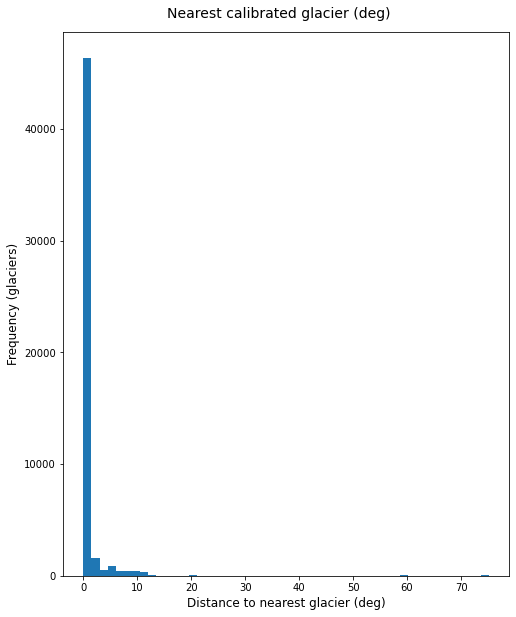

In [8]:
# HISTOGRAMS OF SPREAD
# Setup the pyplot plots
fig = plt.figure(figsize=(8,10)) # Initialize figure with a size
ax1 = fig.add_subplot(111)

labelsize = 12

fig.text(0.5,0.9, 'Nearest calibrated glacier (deg)', ha='center', size=14)

# ===== DEBRIS THICKNESS PLOTS PLOTS =====
# hd dif pixels
h = ax1.hist(main_glac_rgi_missing['nearest_glac_deg'], bins=50)
ax1.set_ylabel('Frequency (glaciers)', size=labelsize)
ax1.set_xlabel('Distance to nearest glacier (deg)', size=labelsize)
print('Med dist med/min/max:', 
      np.median(main_glac_rgi_missing['nearest_glac_deg']), 
      np.min(main_glac_rgi_missing['nearest_glac_deg']), 
      np.max(main_glac_rgi_missing['nearest_glac_deg']))

fig.savefig(debris_prms.output_fp + 'extrap_nearestglac_hist-all.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)

Med dist med/min/max: 12.201364363179344 0.1648676285762028 5298.414661685873


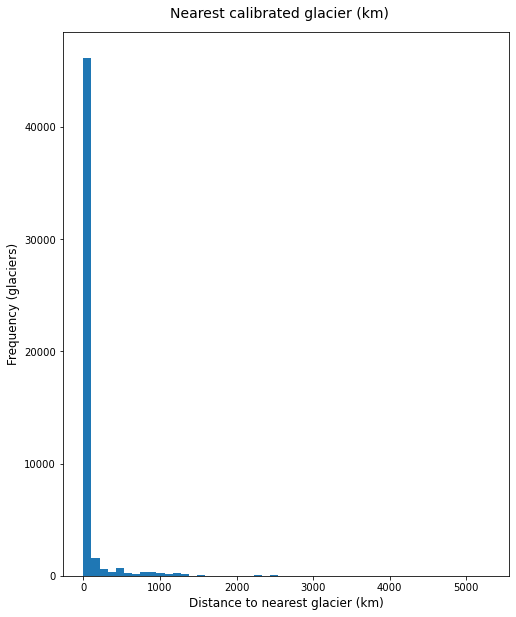

In [9]:
# HISTOGRAMS OF SPREAD
# Setup the pyplot plots
fig = plt.figure(figsize=(8,10)) # Initialize figure with a size
ax1 = fig.add_subplot(111)

labelsize = 12

fig.text(0.5,0.9, 'Nearest calibrated glacier (km)', ha='center', size=14)

# ===== DEBRIS THICKNESS PLOTS PLOTS =====
# hd dif pixels
h = ax1.hist(main_glac_rgi_missing['nearest_glac_km'], bins=50)
ax1.set_ylabel('Frequency (glaciers)', size=labelsize)
ax1.set_xlabel('Distance to nearest glacier (km)', size=labelsize)
print('Med dist med/min/max:', 
      np.median(main_glac_rgi_missing['nearest_glac_km']), 
      np.min(main_glac_rgi_missing['nearest_glac_km']), 
      np.max(main_glac_rgi_missing['nearest_glac_km']))

fig.savefig(debris_prms.output_fp + 'extrap_nearestglac_hist-all-km.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)

In [10]:
main_glac_rgi_missing['roi'] = [str(x).zfill(2) for x in main_glac_rgi_missing['O1Region'].values]
main_glac_rgi_missing.loc[main_glac_rgi_missing['roi'] == '13', 'roi'] = 'HMA'
main_glac_rgi_missing.loc[main_glac_rgi_missing['roi'] == '14', 'roi'] = 'HMA'
main_glac_rgi_missing.loc[main_glac_rgi_missing['roi'] == '15', 'roi'] = 'HMA'
main_glac_rgi_missing.loc[main_glac_rgi_missing['roi'] == 'HMA']

,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,...,Form,TermType,Surging,RefDate,glacno,rgino_str,RGIId_float,nearest_glac_deg,nearest_glac_km,roi
25164,66,RGI60-13.00067,78.2049,35.6232,13,5,0.215,5625,5932,5803,...,0,0,9,20020802,67,13.00067,13.00067,0.639785,70.993172,HMA
25165,79,RGI60-13.00080,78.1672,35.6226,13,5,1.370,5566,6169,5817,...,0,0,9,20020802,80,13.00080,13.00080,0.644484,71.320218,HMA
25166,92,RGI60-13.00093,78.0440,35.5883,13,5,2.019,5432,6095,5795,...,0,0,9,20020802,93,13.00093,13.00093,0.622132,64.558899,HMA
25167,136,RGI60-13.00137,77.9687,35.5987,13,5,2.224,5756,6310,6049,...,1,0,9,20020802,137,13.00137,13.00137,0.587831,59.412175,HMA
25168,174,RGI60-13.00175,78.4507,34.9546,13,5,14.779,5572,6448,5919,...,0,0,9,20020802,175,13.00175,13.00175,0.141240,15.692845,HMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43167,13093,RGI60-15.13094,97.6390,28.9180,15,3,1.294,4822,5447,5169,...,0,0,9,20091014,13094,15.13094,15.13094,0.027803,2.856144,HMA
43168,13096,RGI60-15.13097,80.2200,30.5950,15,1,3.616,5234,5908,5658,...,0,0,9,20110914,13097,15.13097,15.13097,0.044944,4.396431,HMA
43169,13114,RGI60-15.13115,81.9770,30.3370,15,1,1.356,5480,5852,5637,...,0,0,9,20090918,13115,15.13115,15.13115,0.056735,5.459096,HMA
43170,13115,RGI60-15.13116,81.9910,30.3390,15,1,7.427,5266,6232,5633,...,0,0,9,20090918,13116,15.13116,15.13116,0.043247,4.181023,HMA


01 (Med dist med/min/max/95%): 0.1 0.01 21.56 0.54
02 (Med dist med/min/max/95%): 0.39 0.01 11.38 10.18
03 (Med dist med/min/max/95%): 0.67 0.01 4.66 2.33
04 (Med dist med/min/max/95%): 0.18 0.01 5.17 1.05
05 (Med dist med/min/max/95%): 0.38 0.01 4.46 1.71
06 (Med dist med/min/max/95%): 0.21 0.01 3.36 0.83
07 (Med dist med/min/max/95%): 0.17 0.01 11.4 1.04
08 (Med dist med/min/max/95%): 1.21 0.02 16.4 8.86
09 (Med dist med/min/max/95%): 0.87 0.01 11.82 8.25
10 (Med dist med/min/max/95%): 43.79 0.02 75.21 74.76
11 (Med dist med/min/max/95%): 0.06 0.01 7.99 0.4
12 (Med dist med/min/max/95%): 0.13 0.01 12.14 10.2
HMA (Med dist med/min/max/95%): 0.07 0.0 8.64 0.95
16 (Med dist med/min/max/95%): 7.92 0.01 48.71 13.75
17 (Med dist med/min/max/95%): 0.2 0.01 3.22 1.14
18 (Med dist med/min/max/95%): 0.18 0.0 6.1 0.67


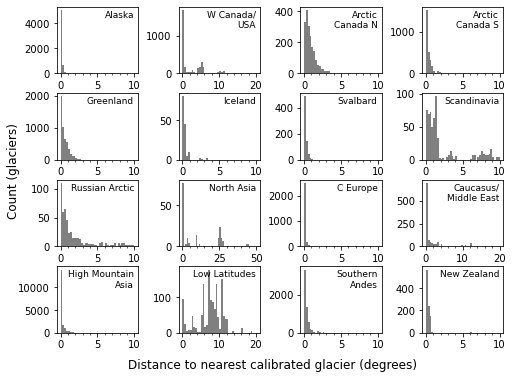

In [11]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(4,4, figsize=(8,6), gridspec_kw = {'wspace':0.5, 'hspace':0.3})
roi_dict_name = {'01':'Alaska',
                 '02':'W Canada/\nUSA',
                 '03':'Arctic\nCanada N',
                 '04':'Arctic\nCanada S',
                 '05':'Greenland',
                 '06':'Iceland',
                 '07':'Svalbard',
                 '08':'Scandinavia',
                 '09':'Russian Arctic',
                 '10':'North Asia',
                 '11':'C Europe',
                 '12':'Caucasus/\nMiddle East',
                 'HMA':'High Mountain\nAsia',
                 '16':'Low Latitudes',
                 '17':'Southern\nAndes',
                 '18':'New Zealand'}

nrow = 0
ncol = 0
for nroi, roi in enumerate(rois):
    main_glac_rgi_missing_roi = main_glac_rgi_missing.loc[main_glac_rgi_missing['roi'] == roi]
    if np.percentile(main_glac_rgi_missing_roi['nearest_glac_deg'],95) < 10:
        bins = list(np.arange(0,10.01,0.25))
        xtick_major = 5
        xtick_minor = 1
    elif np.percentile(main_glac_rgi_missing_roi['nearest_glac_deg'],95) < 20:
        bins = list(np.arange(0,20.01,0.5))
        xtick_major = 10
        xtick_minor = 2
    else:
        bins = list(np.arange(0,50.01,1))
        xtick_major = 25
        xtick_minor = 5
    ax[nrow,ncol].hist(main_glac_rgi_missing_roi['nearest_glac_deg'], bins=bins, color='grey')
    ax[nrow,ncol].text(0.95,0.95, roi_dict_name[roi], ha='right', va='top', 
                       transform=ax[nrow, ncol].transAxes, size=9)
#     ax[nrow,ncol].set_xticks(xticks)
    ax[nrow,ncol].xaxis.set_major_locator(MultipleLocator(xtick_major))
    ax[nrow,ncol].xaxis.set_minor_locator(MultipleLocator(xtick_minor))
    print(roi + ' (Med dist med/min/max/95%):', 
          np.round(np.median(main_glac_rgi_missing_roi['nearest_glac_deg']),2), 
          np.round(np.min(main_glac_rgi_missing_roi['nearest_glac_deg']),2), 
          np.round(np.max(main_glac_rgi_missing_roi['nearest_glac_deg']),2),
          np.round(np.percentile(main_glac_rgi_missing_roi['nearest_glac_deg'],95),2))
    
    ncol = ncol + 1
    if ncol%4 == 0:
        nrow = nrow+1
        ncol = 0
    
fig.text(0.05,0.5, 'Count (glaciers)', ha='center', va='center', rotation='vertical', size=12)
fig.text(0.5,0.05, 'Distance to nearest calibrated glacier (degrees)', ha='center', va='center', size=12)
fig.savefig(debris_prms.output_fp + 'extrap_nearestglac_hist-rois.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)

01 (Med dist med/min/max/95%): 8.19 0.41 1470.54 26.95
02 (Med dist med/min/max/95%): 36.24 0.94 1249.63 521.92
03 (Med dist med/min/max/95%): 30.76 0.79 151.14 86.75
04 (Med dist med/min/max/95%): 11.94 0.66 552.28 51.56
05 (Med dist med/min/max/95%): 21.51 0.7 245.26 78.97
06 (Med dist med/min/max/95%): 13.74 1.25 172.54 36.78
07 (Med dist med/min/max/95%): 8.29 1.09 502.6 41.26
08 (Med dist med/min/max/95%): 85.05 1.57 831.77 628.22
09 (Med dist med/min/max/95%): 36.43 1.46 367.13 205.49
10 (Med dist med/min/max/95%): 1480.33 1.62 2826.19 2535.78
11 (Med dist med/min/max/95%): 5.42 0.47 742.34 23.22
12 (Med dist med/min/max/95%): 12.07 0.48 1280.22 381.06
HMA (Med dist med/min/max/95%): 7.38 0.27 891.57 63.66
16 (Med dist med/min/max/95%): 865.69 1.49 5298.41 1262.62
17 (Med dist med/min/max/95%): 19.1 0.46 349.95 74.17
18 (Med dist med/min/max/95%): 17.47 0.16 586.47 53.81


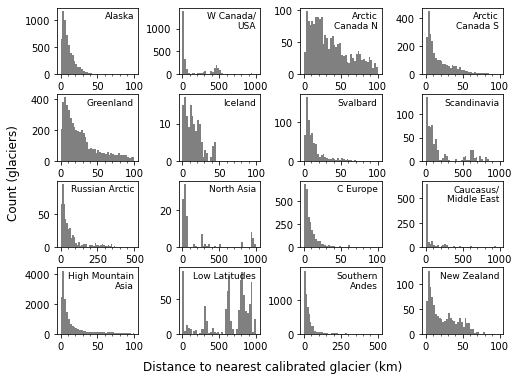

In [20]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(4,4, figsize=(8,6), gridspec_kw = {'wspace':0.5, 'hspace':0.3})
roi_dict_name = {'01':'Alaska',
                 '02':'W Canada/\nUSA',
                 '03':'Arctic\nCanada N',
                 '04':'Arctic\nCanada S',
                 '05':'Greenland',
                 '06':'Iceland',
                 '07':'Svalbard',
                 '08':'Scandinavia',
                 '09':'Russian Arctic',
                 '10':'North Asia',
                 '11':'C Europe',
                 '12':'Caucasus/\nMiddle East',
                 'HMA':'High Mountain\nAsia',
                 '16':'Low Latitudes',
                 '17':'Southern\nAndes',
                 '18':'New Zealand'}

nrow = 0
ncol = 0
for nroi, roi in enumerate(rois):
    main_glac_rgi_missing_roi = main_glac_rgi_missing.loc[main_glac_rgi_missing['roi'] == roi]
    if np.percentile(main_glac_rgi_missing_roi['nearest_glac_km'],95) < 100:
        bins = list(np.arange(0,100.01,2.5))
        xtick_major = 50
        xtick_minor = 10
#     elif np.percentile(main_glac_rgi_missing_roi['nearest_glac_km'],95) < 500:
#         bins = list(np.arange(0,500.01,10))
#         xtick_major = 250
#         xtick_minor = 50
    else:
        bins = list(np.arange(0,1000.01,25))
        xtick_major = 500
        xtick_minor = 100
        
    ax[nrow,ncol].hist(main_glac_rgi_missing_roi['nearest_glac_km'], bins=bins, color='grey')
    ax[nrow,ncol].text(0.95,0.95, roi_dict_name[roi], ha='right', va='top', 
                       transform=ax[nrow, ncol].transAxes, size=9)
    ax[nrow,ncol].xaxis.set_major_locator(MultipleLocator(xtick_major))
    ax[nrow,ncol].xaxis.set_minor_locator(MultipleLocator(xtick_minor))
    print(roi + ' (Med dist med/min/max/95%):', 
          np.round(np.median(main_glac_rgi_missing_roi['nearest_glac_km']),2), 
          np.round(np.min(main_glac_rgi_missing_roi['nearest_glac_km']),2), 
          np.round(np.max(main_glac_rgi_missing_roi['nearest_glac_km']),2),
          np.round(np.percentile(main_glac_rgi_missing_roi['nearest_glac_km'],90),2))
    
    ncol = ncol + 1
    if ncol%4 == 0:
        nrow = nrow+1
        ncol = 0
    
fig.text(0.05,0.5, 'Count (glaciers)', ha='center', va='center', rotation='vertical', size=12)
fig.text(0.5,0.05, 'Distance to nearest calibrated glacier (km)', ha='center', va='center', size=12)
fig.savefig(debris_prms.output_fp + 'extrap_nearestglac_hist-rois-km.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)